<a href="https://colab.research.google.com/github/GreatGameDota/SIIM-ISIC-Melanoma-Classification/blob/master/train_meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Aug 17 14:35:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Download data

In [ ]:
import json
import zipfile
import os
os.chdir('/content')

!pip install kaggle --quiet

api_token = {"username":"greatgamedota","key":""} # Get the key from create new api token on https://www.kaggle.com/greatgamedota/account
!mkdir /root/.kaggle # create a dir for key
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json # make sure no one else can read the key

if not os.path.isdir('train/'):
  !kaggle datasets download -d cdeotte/jpeg-melanoma-512x512
  !unzip -q jpeg-melanoma-512x512.zip
  !rm jpeg-melanoma-512x512.zip

  !kaggle datasets download -d cdeotte/jpeg-isic2019-512x512
  !unzip -q jpeg-isic2019-512x512.zip -d 'isic2019/'
  !rm jpeg-isic2019-512x512.zip
  
  !kaggle datasets download -d cdeotte/malignant-v2-512x512
  !unzip -q malignant-v2-512x512.zip -d 'isic/'
  !rm malignant-v2-512x512.zip

  !kaggle datasets download -d nroman/melanoma-hairs
  !unzip -q melanoma-hairs -d 'hairs/'
  !rm melanoma-hairs.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists


#### .

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm,trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp

# from apex import amp

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

class config:
    epochs = 15
    batch_size = 16
    regression = False
    num_classes = 1
    meta_features = 9
    IMAGE_PATH = 'train/'
    TEST_PATH = 'test/'
    lr = 1e-4
    # lr = 3e-4
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225],
    seed = 42
    mixup = 0
    cutmix = 0
    accumulation_steps = 1
    single_fold = 4
    folds = 5
    apex = False
    scale = True
    label_smoothing = 0.03
    pos_weight = 1

import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

In [ ]:
train_df1 = pd.read_csv('train.csv')
train_df3 = pd.read_csv('isic2019/train.csv')
# train_df2 = pd.concat([train_df1,train_df3[train_df3['target']==1]])
train_df2 = train_df1

In [ ]:
train_df4 = pd.read_csv('isic/train_malig_1.csv') # 584 2020
train_df5 = pd.read_csv('isic/train_malig_2.csv') # 580 ISIC Website
train_df6 = pd.read_csv('isic/train_malig_3.csv') # 2018/9

#### Meta Data

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target', 'tfrecord', 'width', 'height'
]
test.columns = ['img_name', 'id', 'sex', 'age', 'location', 'width', 'height']

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)

# train['sex'].fillna(train['sex'].mode()[0], inplace=True)
train['sex'].fillna('na', inplace=True)

# train['age'].fillna(train['age'].median(), inplace=True)
train['age'].fillna(-5, inplace=True)

sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)

anatom_dummies = pd.get_dummies(train['location'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['location'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)

train.drop(['sex', 'sex_na', 'location', 'anatom_unknown', 'target','id','diagnosis','benign_malignant', 'width', 'height', 'tfrecord'], axis=1, inplace=True)
test.drop(['sex', 'anatom_unknown', 'location', 'id','width', 'height'], axis=1, inplace=True)

train.head()

,img_name,age,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity
0,ISIC_2637011,45.0,0,1,1,0,0,0,0,0
1,ISIC_0015719,45.0,1,0,0,0,0,0,0,1
2,ISIC_0052212,50.0,1,0,0,1,0,0,0,0
3,ISIC_0068279,45.0,1,0,1,0,0,0,0,0
4,ISIC_0074268,55.0,1,0,0,0,0,0,0,1


In [ ]:
test.head()

,img_name,age,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity
0,ISIC_0052060,70.0,0,1,0,0,0,0,0,0
1,ISIC_0052349,40.0,0,1,0,1,0,0,0,0
2,ISIC_0058510,55.0,1,0,0,0,0,0,1,0
3,ISIC_0073313,50.0,1,0,0,0,0,0,1,0
4,ISIC_0073502,45.0,1,0,0,1,0,0,0,0


In [ ]:
train2 = pd.read_csv('isic2019/train.csv')

train2.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target', 'tfrecord', 'width', 'height'
]

train2['location'].fillna('unknown', inplace=True)

# train['sex'].fillna(train['sex'].mode()[0], inplace=True)
train2['sex'].fillna('na', inplace=True)

# train['age'].fillna(train['age'].median(), inplace=True)
train2['age'].fillna(-5, inplace=True)

sex_dummies = pd.get_dummies(train2['sex'], prefix='sex')
train2 = pd.concat([train2, sex_dummies], axis=1)

anatom_dummies = pd.get_dummies(train2['location'], prefix='anatom')
train2 = pd.concat([train2, anatom_dummies], axis=1)

cols = ['anatom_anterior torso', 'anatom_lateral torso', 'anatom_posterior torso']
train2['anatom_torso'] = train2[cols].sum(1)

train2.drop(['sex', 'sex_unknown', 'location', 'anatom_unknown', 'target','id','diagnosis','benign_malignant', 'width', 'height', 'tfrecord'], axis=1, inplace=True)
train2.drop(cols, axis=1, inplace=True)

cols = ['anatom_upper extremity',	'anatom_torso']
train2 = train2[[c for c in train2 if c not in cols] + [cols[1], cols[0]]]

train2.head()

,img_name,age,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity
0,ISIC_0000000,55.0,1,0,0,0,0,0,1,0
1,ISIC_0000001,30.0,1,0,0,0,0,0,1,0
2,ISIC_0000002,60.0,1,0,0,0,0,0,0,1
3,ISIC_0000003,30.0,0,1,0,0,0,0,0,1
4,ISIC_0000004,80.0,0,1,0,0,0,0,1,0


In [ ]:
train5 = pd.read_csv('isic/train_malig_2.csv') # 580 ISIC Website

train5.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target', 'width', 'height', 'source', 'ext', 'tfrecord'
]

train5['location'].fillna('unknown', inplace=True)

train5['sex'].fillna('na', inplace=True)

train5['age'].fillna(-5, inplace=True)

sex_dummies = pd.get_dummies(train5['sex'], prefix='sex')
train5 = pd.concat([train5, sex_dummies], axis=1)

anatom_dummies = pd.get_dummies(train5['location'], prefix='anatom')
train5 = pd.concat([train5, anatom_dummies], axis=1)

cols = ['anatom_anterior torso', 'anatom_lateral torso', 'anatom_posterior torso']
train5['anatom_torso'] = train5[cols].sum(1)

train5.drop(['sex', 'sex_na', 'location', 'anatom_unknown', 'target','id','diagnosis','benign_malignant', 'width', 'height', 'tfrecord', 'source', 'ext'], axis=1, inplace=True)
train5.drop(cols, axis=1, inplace=True)

cols = ['anatom_upper extremity',	'anatom_torso']
train5 = train5[[c for c in train5 if c not in cols] + [cols[1], cols[0]]]

train5['anatom_oral/genital'] = 0

cols = ['anatom_palms/soles', 'anatom_torso', 'anatom_upper extremity']
train5 = train5[[c for c in train5 if c not in cols] + [cols[0], cols[1], cols[2]]]

train5.head()

,img_name,age,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity
0,ISIC_0000070,25.0,0,1,0,0,0,0,1,0
1,ISIC_0000076,55.0,0,1,0,0,0,0,1,0
2,ISIC_0000144,-5.0,0,0,0,0,0,0,0,0
3,ISIC_0000158,30.0,1,0,0,0,0,0,0,1
4,ISIC_0000284,80.0,0,1,1,0,0,0,0,0


In [ ]:
meta_df = pd.concat([train, train2, train5])
test_meta_df = test

#### Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, meta_df, root_dir, folds, transform=None, mode='train'):
        self.df = dataframe
        self.meta_df = meta_df
        self.root_dir = root_dir
        self.transform = transform
        self.folds = folds
        self.mode = mode

        self.paths = self.df.image_name.values
        self.labels = self.df['target'].values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.paths[idx]
        imgs = []
        img_path = f'{self.root_dir}{img_name}.jpg'
        img = cv2.imread(img_path)
        if img is None:
          img_path = f'isic2019/{self.root_dir}{img_name}.jpg'
          img = cv2.imread(img_path)
          if img is None:
            img_path = f'isic/jpeg512/{img_name}.jpg'
            img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
          img = self.transform(image=img)['image']
        # imgs = (255 - imgs).astype(np.float32) / 255.
        img = np.rollaxis(img, -1, 0)

        meta_data = np.array(self.meta_df[self.meta_df['img_name']==img_name].values[0][1:]).astype(np.float32)
        # Meta Aug
        if self.mode == 'train' or self.mode == 'val2' or self.mode == 'test2':
          if torch.rand(1) < 0.1:
            meta_data[0] = -5
          if torch.rand(1) < 0.1:
            meta_data[3:] = 0
          if torch.rand(1) < 0.1:
            meta_data[1:3] = 0

        if self.mode != 'test' and self.mode != 'test2':
          labels = np.array(self.labels[idx]).astype(np.long)
          return [img, meta_data, labels]
        else:
          return [img, meta_data]

#### Model

In [ ]:
!pip install pytorchcv --quiet
!pip install timm --quiet
import timm
from pytorchcv.model_provider import get_model

class FCN(torch.nn.Module):
  def __init__(self, base, in_f, num_classes, in_meta, dropout=True):
    super(FCN, self).__init__()
    self.base = base
    self.after_model = nn.Sequential(
        nn.Dropout(0.4, inplace=False),
        nn.Flatten()
    )
    self.classification = nn.Sequential(
        nn.Linear(in_f, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, num_classes)
    )
    self.meta = nn.Sequential(
        # nn.Linear(in_meta, 256),
        # nn.BatchNorm1d(256),
        # nn.ReLU(),
        # nn.Dropout(0.4),
        # nn.Linear(256, 512),
        # nn.BatchNorm1d(512),
        # nn.ReLU(),
        # nn.Dropout(0.4)

        nn.Linear(in_meta, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.8),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    self.classification_meta = nn.Sequential(
        nn.Linear(in_f+512, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, num_classes)
    )
  
  def forward(self, x, meta):
    x = self.base(x)
    x = self.after_model(x)
    meta = self.meta(meta)
    features = torch.cat((x,meta),dim=1)
    x = self.classification_meta(features)
    return x

def create_model(name, freeze=False):
    model = get_model(name, pretrained=True)
    # model = timm.create_model(name, pretrained=True)
    try:
      features = list(model.children())[-1].in_features
    except:
      try:
        features = list(model.children())[-1][-1].in_features
      except:
        features = list(model.children())[-2].in_features
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    # model[0].final_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    # model[-1] = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    
    # Freeze Backbone
    if freeze:
      for name, param in model.named_parameters():
        # if("bn" not in name):
        param.requires_grad = False
    
    model = FCN(model, features, config.num_classes, config.meta_features, dropout=True)
    
    return model

model = create_model("efficientnet_b4b")
model.parameters

#### Train funcs

In [ ]:
# Focal loss from: https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py
def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

def criterion1(pred1, targets):
  y_smo = targets * (1 - config.label_smoothing) + 0.5 * config.label_smoothing
  # l1 = F.binary_cross_entropy_with_logits(pred1[:,0], y_smo, pos_weight=torch.tensor(config.pos_weight))
  l1 = sigmoid_focal_loss(pred1[:,0], y_smo, alpha=0.75, reduction='mean')
  return l1

def train_model(epoch, optimizer, scaler=None, scheduler=None, history=None):
    model.train()
    total_loss = 0

    t = tqdm(train_loader)
    for batch_idx, (img_batch, meta_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        y_batch = y_batch.cuda().float()
        meta_batch = meta_batch.cuda().float()
        
        rand = np.random.rand()
        if rand < config.mixup:
            pass
        elif rand < config.cutmix:
            pass
        else:
            if config.scale:
              with amp.autocast():
                output1 = model(img_batch, meta_batch)
                loss = criterion1(output1, y_batch) / config.accumulation_steps
            else:
              output1 = model(img_batch, meta_batch)
              loss = criterion1(output1, y_batch) / config.accumulation_steps

        total_loss += loss.data.cpu().numpy() * config.accumulation_steps
        t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(batch_idx+1)))

        if history is not None:
          history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + batch_idx / len(train_loader), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']
        
        if config.scale:
          scaler.scale(loss).backward()
        elif config.apex:
          with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        else:
          loss.backward()
        
        if (batch_idx+1) % config.accumulation_steps == 0:
          if config.scale:
            scaler.step(optimizer)
            scaler.update()
          else:
            optimizer.step()
          optimizer.zero_grad()
        
        if scheduler is not None:
          scheduler.step(epoch)

def evaluate_model(epoch, scheduler=None, history=None, no_log=False):
    model.eval()
    loss = 0
    
    preds_1 = []
    tars_1 = []
    with torch.no_grad():
        t = tqdm(val_loader)
        for img_batch, meta_batch, y_batch in t:
            img_batch = img_batch.cuda().float()
            y_batch = y_batch.cuda().float()
            meta_batch = meta_batch.cuda().float()

            o1 = model(img_batch, meta_batch)

            l1 = criterion1(o1, y_batch)
            loss += l1

            for j in range(len(o1)):
              preds_1.append(o1[j].data.cpu().numpy())
            for i in y_batch:
              tars_1.append(i.data.cpu().numpy())
    
    preds_1 = np.array(preds_1).T.reshape(-1)
    
    final_score = roc_auc_score(tars_1, preds_1)
    
    loss /= len(val_loader)
    
    if history is not None:
      history.loc[epoch, 'val_loss'] = loss.cpu().numpy()
      history.loc[epoch, 'auc'] = final_score
    
    if scheduler is not None:
      scheduler.step(final_score)

    print(f'Dev loss: %.4f, AUC: {final_score}'%(loss))
      
    if not no_log:
      with open(log_name, 'a') as f:
        f.write(f'val loss: {loss}\n')
        f.write(f'val AUC: {final_score}\n')

    return tars_1, preds_1, loss, final_score

#### Dataset

In [ ]:
!pip install albumentations==0.4.3 --quiet
import albumentations as A

# From: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159176#961899
from albumentations.core.transforms_interface import ImageOnlyTransform

class AdvancedHairAugmentation(ImageOnlyTransform):
  def __init__(self, hairs: int = 4, hairs_folder: str = "", always_apply=False, p=0.5):
      super(AdvancedHairAugmentation, self).__init__(always_apply=always_apply, p=p)
      self.hairs = hairs
      self.hairs_folder = hairs_folder

  def apply(self, image, **params):
      n_hairs = random.randint(0, self.hairs)

      if not n_hairs:
          return image

      height, width, _ = image.shape  # target image width and height
      hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]

      for _ in range(n_hairs):
          hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
          hair = cv2.cvtColor(hair, cv2.COLOR_BGR2RGB)
          hair = cv2.flip(hair, random.choice([-1, 0, 1]))
          hair = cv2.rotate(hair, random.choice([0, 1, 2]))

          h_height, h_width, _ = hair.shape  # hair image width and height
          roi_ho = random.randint(0, image.shape[0] - hair.shape[0])
          roi_wo = random.randint(0, image.shape[1] - hair.shape[1])
          roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

          img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
          ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
          mask_inv = cv2.bitwise_not(mask)
          img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
          hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

          dst = cv2.add(img_bg, hair_fg)
          image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
      return image

  def get_params_dependent_on_targets(self, params):
      return {}

  @property
  def targets_as_params(self):
      return ["image"]

  def get_transform_init_args_names(self):
      return ()

In [ ]:
# From: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159476#900271
class Microscope(A.ImageOnlyTransform):
    def __init__(self, p: float = 0.5, always_apply=False):
        super().__init__(always_apply, p)

    def apply(self, img, **params):
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8),
                        (img.shape[0]//2, img.shape[1]//2),
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15),
                        (0, 0, 0),
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)

        return img

train_transform = A.Compose([
                            A.OneOf([
                              A.ShiftScaleRotate(scale_limit=.15, rotate_limit=80, shift_limit=0.1, border_mode=cv2.BORDER_REPLICATE, p=0.5),
                              A.IAAAffine(shear=20, mode='constant', p=0.5),
                              A.IAAPerspective(p=0.5),
                            ], p=0.5),
                            
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                             
                            # AdvancedHairAugmentation(hairs=10, hairs_folder='hairs/', p=0.5),
                            A.RandomBrightnessContrast(),
                            
                            A.Cutout(num_holes=8, max_h_size=512//8, max_w_size=512//8, fill_value=0, p=0.3),
                            Microscope(p=0.1),
                            A.Normalize(always_apply=True)
])

val_transform = A.Compose([
                          A.Normalize(always_apply=True)
])

skf = KFold(n_splits=config.folds,shuffle=True,random_state=config.seed)

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
  train_dataset = ImageDataset(train_df2, meta_df, config.IMAGE_PATH, folds=idxT, transform=train_transform)
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

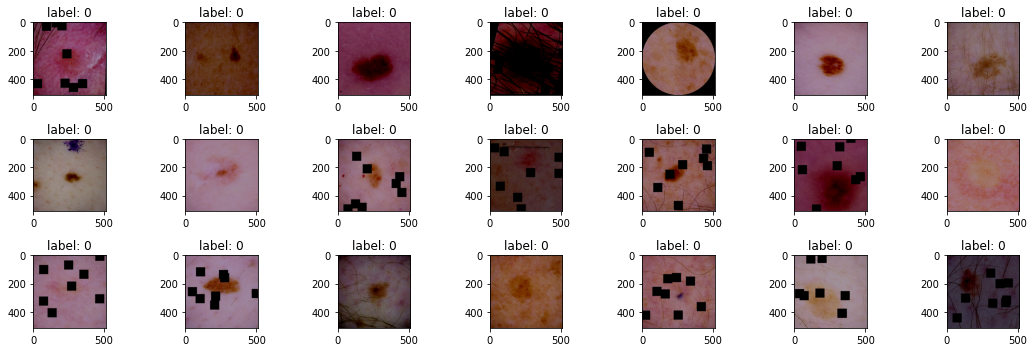

In [ ]:
nrow, ncol = 3, 7
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, _, label = train_dataset[i]
    image = np.rollaxis(image, 0, 3)
    image = (image + config.mean) * config.std
    ax.imshow(image)
    ax.set_title(f'label: {label}')
plt.tight_layout()

#### Training

In [ ]:
import gc
validations = []

log_name = f"drive/My Drive/logs/log-{len(os.listdir('drive/My Drive/logs/'))}.log"

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
  if fold == config.single_fold:
    print(f'Train Fold {fold+1}')
    with open(log_name, 'a') as f:
      f.write(f'Train Fold {config.single_fold+1}\n\n')

    history = pd.DataFrame()
    history2 = pd.DataFrame()

    torch.cuda.empty_cache()
    gc.collect()

    best = -1e10
    best2 = 1e10
    n_epochs = config.epochs
    early_epoch = 0

    t3 = train_df2[train_df2.tfrecord.isin(idxV).reset_index(drop=True)]
    val_dataset = ImageDataset(t3, meta_df, config.IMAGE_PATH, folds=idxV, transform=val_transform, mode='val')

    data2019 = idxT*2+1
    data2018 = idxT*2
    
    external = train_df3[train_df3.tfrecord.isin(data2018).reset_index(drop=True)]
    external2 = train_df3[train_df3.tfrecord.isin(data2019).reset_index(drop=True)]
    train_data = train_df2[train_df2.tfrecord.isin(idxT).reset_index(drop=True)]

    upsam_2020 = train_df4[train_df4.tfrecord.isin(idxT).reset_index(drop=True)]
    upsam_isic = train_df5[train_df5.tfrecord.isin(idxT+15).reset_index(drop=True)]
    upsam_2019 = train_df6[train_df6.tfrecord.isin(data2019+30).reset_index(drop=True)]
    upsam_2018 = train_df6[train_df6.tfrecord.isin(data2018+30).reset_index(drop=True)]

    external.drop(external.tail(1).index,inplace=True)
    train_df2 = pd.concat([train_data, external, upsam_2020, upsam_isic, upsam_2018])

    train_dataset = ImageDataset(train_df2, meta_df, config.IMAGE_PATH, folds=idxT, transform=train_transform)

    BATCH_SIZE = config.batch_size
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False, num_workers=0)

    scaler = amp.GradScaler()

    model = create_model("efficientnet_b4b", freeze=False)
    model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    
    if config.apex:
      model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='max', factor=0.75, verbose=True, min_lr=1e-5)

    for epoch in range(n_epochs-early_epoch):
        epoch += early_epoch
        torch.cuda.empty_cache()
        gc.collect()

        with open(log_name, 'a') as f:
          f.write(f'XXXXXXXXXXXXXX-- CYCLE INTER: {epoch+1} --XXXXXXXXXXXXXXXXXXX\n')
          lr_ = optimizer.state_dict()['param_groups'][0]['lr']
          f.write(f'curr lr: {lr_}\n')
        
        train_model(epoch, optimizer, scaler=scaler, scheduler=None, history=history)
        
        tars_1, preds_1, loss, kaggle = evaluate_model(epoch, scheduler=scheduler, history=history2)

        if kaggle > best:
          best = kaggle
          print(f'Saving best model... (auc)')
          torch.save({
            'model_state': model.state_dict(),
          }, f'drive/My Drive/Models/model-fld2.pth')
          with open(log_name, 'a') as f:
            f.write('Saving Best model... (auc)\n\n')
        else:
          with open(log_name, 'a') as f:
            f.write('\n')
        if loss < best2:
          best2 = loss
          print(f'Saving best model... (loss)')
          torch.save({
            'model_state': model.state_dict(),
          }, f'drive/My Drive/Models/model-fld2-1.pth')
          with open(log_name, 'a') as f:
            f.write('Saving Best model... (loss)\n\n')
        else:
          with open(log_name, 'a') as f:
            f.write('\n')
    print()
    validations.append(best)
    break

Train Fold 5


100%|██████████| 103/103 [02:59<00:00,  1.74s/it]


Dev loss: 0.0113, AUC: 0.8936469626124798
Saving best model... (auc)
Saving best model... (loss)


100%|██████████| 103/103 [02:56<00:00,  1.71s/it]


Dev loss: 0.0107, AUC: 0.896938052110466
Saving best model... (auc)
Saving best model... (loss)


100%|██████████| 103/103 [02:55<00:00,  1.71s/it]


Dev loss: 0.0110, AUC: 0.9040559126766023
Saving best model... (auc)


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0120, AUC: 0.8742973742973742


100%|██████████| 103/103 [02:55<00:00,  1.71s/it]


Dev loss: 0.0130, AUC: 0.9117287048321532
Saving best model... (auc)


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0157, AUC: 0.8984992950510191


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0148, AUC: 0.895715343991206


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0188, AUC: 0.9016177981695224


  0%|          | 0/2416 [00:00<?, ?it/s]

Epoch     9: reducing learning rate of group 0 to 7.5000e-05.
Dev loss: 0.0167, AUC: 0.9005809523050903


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0189, AUC: 0.8978793116724151


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0196, AUC: 0.880716260026605


  0%|          | 0/2416 [00:00<?, ?it/s]

Dev loss: 0.0210, AUC: 0.8725184070011656


Epoch 13/15, LR: 0.000075, Loss: 0.0008:   0%|          | 1/2416 [00:02<1:34:50,  2.36s/it]

KeyboardInterrupt: ignored

In [ ]:
history2['auc'].plot()

In [ ]:
# drive.flush_and_unmount()

In [ ]:
model = create_model("efficientnet_b4b")
model = model.cuda()
model.load_state_dict(torch.load('drive/My Drive/Models/model-fld2.pth')['model_state'])

test_df = pd.read_csv('sample_submission.csv')

test_transform = A.Compose([
                          A.Normalize(always_apply=True)
])

test_dataset = ImageDataset(test_df, test_meta_df, config.TEST_PATH, folds=None, transform=test_transform, mode='test')
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=0)

preds = []

model.eval()
loss = 0

preds_1 = []
tars_1 = []
with torch.no_grad():
    t = tqdm(test_loader)
    for img_batch, meta_batch in t:
        img_batch = img_batch.cuda().float()
        meta_batch = meta_batch.cuda().float()
        o1 = model(img_batch, meta_batch)

        for j in range(len(o1)):
          preds_1.append(o1[j])

preds_1 = [p.data.cpu().numpy()[0] if type(p) != int else p for p in preds_1]
preds_1 = np.array(preds_1).T.reshape(-1)
test_df['target'] = preds_1
test_df.to_csv('drive/My Drive/submission2.csv', index=False)

In [ ]:
test_df.head()

In [ ]:
_ = plt.hist(preds_1, bins=100)

In [ ]:
# !kaggle competitions submit -c siim-isic-melanoma-classification -f "drive/My Drive/submission2.csv" -m "Message"

In [ ]:
def tta_pred(df, meta_df, path, transform, tta_rounds, mode='val'):
  val_dataset = ImageDataset(df, meta_df, path, folds=idxV, transform=transform, mode=mode)
  val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=0)

  model.eval()
  all_preds = np.zeros((len(val_dataset),tta_rounds,config.num_classes))
  with torch.no_grad():
    for i in range(tta_rounds):
      preds_1 = []
      tars_1 = []
      t = tqdm(val_loader)
      if mode == 'val' or mode == 'val2':
        for (img_batch, meta_batch, y_batch) in t:
          img_batch = img_batch.cuda().float()
          meta_batch = meta_batch.cuda().float()
          o1 = model(img_batch, meta_batch)

          for j in range(len(o1)):
            preds_1.append(o1[j])
          for i in y_batch:
            tars_1.append(i.data.cpu().numpy())
      elif mode == 'test' or mode == 'test2':
        for img_batch, meta_batch in t:
          img_batch = img_batch.cuda().float()
          meta_batch = meta_batch.cuda().float()
          o1 = model(img_batch, meta_batch)

          for j in range(len(o1)):
            preds_1.append(o1[j])
          
      all_preds[:,i] = [p.data.cpu().numpy() for p in preds_1]

  preds_1 = np.mean(all_preds, axis=1)
  preds_1 = np.array(preds_1).T.reshape(-1)
  if mode == 'val' or mode == 'val2':
    return preds_1, tars_1
  else:
    return preds_1

In [ ]:
model = create_model("efficientnet_b4b")
model = model.cuda()
model.load_state_dict(torch.load('drive/My Drive/Models/model-fld2.pth')['model_state'])

test_df = pd.read_csv('sample_submission.csv')

test_transform = A.Compose([
                          A.Normalize(always_apply=True)
])

train_transform = A.Compose([
                            A.OneOf([
                              A.ShiftScaleRotate(scale_limit=.15, rotate_limit=80, shift_limit=0.1, border_mode=cv2.BORDER_REPLICATE, p=0.5),
                              A.IAAAffine(shear=20, mode='constant', p=0.5),
                              A.IAAPerspective(p=0.5),
                            ], p=0.5),
                             
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                             
                            # AdvancedHairAugmentation(hairs=10, hairs_folder='hairs/', p=0.5),
                            A.RandomBrightnessContrast(),
                            
                            A.Cutout(num_holes=8, max_h_size=512//8, max_w_size=512//8, fill_value=0, p=0.3),
                            Microscope(p=0.1),
                            A.Normalize(always_apply=True)
])

BATCH_SIZE = config.batch_size

# train_df2 = pd.read_csv('train.csv')
# t3 = train_df2[train_df2.tfrecord.isin(idxV).reset_index(drop=True)]
# preds_1, tars_1 = tta_pred(t3, meta_df, config.IMAGE_PATH, train_transform, 1, mode='val')
# preds_1, tars_1 = tta_pred(t3, meta_df, config.IMAGE_PATH, test_transform, 1, mode='val')

preds_1 = tta_pred(test_df, test_meta_df, config.TEST_PATH, train_transform, 10, mode='test2')

test_df['target'] = preds_1
test_df.to_csv('drive/My Drive/submission.csv', index=False)

In [ ]:
test_df.head()

,image_name,target
0,ISIC_0052060,-5.519484
1,ISIC_0052349,-6.483155
2,ISIC_0058510,-6.977476
3,ISIC_0073313,-6.525477
4,ISIC_0073502,-2.064997


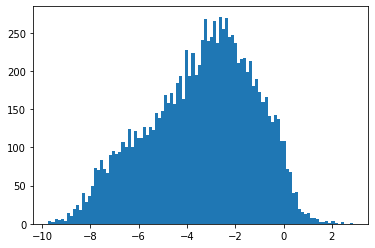

In [ ]:
_ = plt.hist(preds_1, bins=100)

In [ ]:
# !kaggle competitions submit -c siim-isic-melanoma-classification -f 'drive/My Drive/submission.csv' -m "Message"

In [ ]:
# final_score = roc_auc_score(tars_1, preds_1)
# print(f'AUC with TTA: {final_score}')